# IHC Attribution API Example Usage

**API URL: https://api.advanced-attribution.com**


We have 4 API endpoints:
- **/train-ihc-parameter**: 
    - the Initializer and Closer membership functions are trained on a provided set of CJs
    - the parameter are returned
    - the parameter are stored in a  database for use in later computations, with the keys:
        - account: identifier for potential different platforms
        - market: identifier for different markets
        - conv_code: identifier for different conversion types
- **/compute-ihc-with-stored-parameter**:
    - compute the IHC attribution based on stored parameter
- **/compute-ihc**:
    - compute the IHC attribution based on parameter provided in the request
- **/get-stored-ihc-parameter**:
    - return all stored ihc parameter

In [2]:
import json
import requests
import pprint

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline

def linear_membership(t,a=2.0, x_offset=0.125):
    x_shifted = t-x_offset
    y_shifted = max(0, (x_shifted/(a-x_offset) ) )
    return min(y_shifted, 1)

## Configuration

Here, the user needs to put the API Key received from https://advanced-attribution.com/

In [3]:
api_url = 'https://api.advanced-attribution.com'
api_key = '{api_key}'

## Define where to save the resulting IHC Parameters
account = 'ihc-webservice-test-account'
conv_code = 'ihc-webservice-test-conv_code'
market = 'INT'

## Define Estimation Parameter
initializer_outlier_quantile = '80'
initializer_quantile = '90'
closer_outlier_quantile = '80'
closer_quantile = '90'

## Customer Journeys

Here, we read in the example customer journeys. Please refer to the example customer journeys as the format guideline for estimating IHC Parameters. We require the customer_journeys object to be a list of sessions, whereas multiple sessions make up one customer journey.
Each session is a dictionary with the following keys:
- **'event_datetime'** (str: timestamp of the session in format '%Y-%m-%d %H:%M:%S', e.g. '2020-06-22 16:42:11')
- **'conversion_id'** (str: identifier of the conversion event that this belongs to; each session belongs to one conversion and multiple sessions belonging to one conversion make up one customer journey)
- **'closer_valid'** (boolean: if the session should receive 'Closer' Attribution scores in the given customer journey; generally the last session in each customer journey should be 'Closer Valid')

In [4]:
with open('./example_data/example_cjs_estimation.txt') as json_file:
    customer_journeys = json.load(json_file)

## Send Request to Estimate IHC Parameter

In [5]:
## Create Request Body

body = {
    'conversion_metadata': {
        'account': account,
        'market': market,
        'conv_code': conv_code
    },
    'estimation_parameter': {
        'initializer_outlier_quantile': initializer_outlier_quantile,
        'initializer_quantile': initializer_quantile,
        'closer_outlier_quantile': closer_outlier_quantile,
        'closer_quantile': closer_quantile
    },
    'customer_journeys': customer_journeys
}

In [6]:
response = requests.post(
    api_url + '/train-ihc-parameter', 
    data=json.dumps(body), 
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': api_key
}
) 
ihc_results = json.loads(response.content)
pprint.pprint( ihc_results )

{'Message': 'Successfully estimated IHC parameters for given input.',
 'closer_end_value_distribution': [0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
                                   0.0,
          

In [7]:
## Reading out the Membership Function from the Request Response and the Closer and Initializer Distributions
try:
    estimated_membership_functions = json.loads(response.content.decode("utf-8"))['membership_functions']['membership_functions']
    initializer_end_value_distribution = json.loads(response.content.decode("utf-8"))['initializer_end_value_distribution']
    closer_end_value_distribution = json.loads(response.content.decode("utf-8"))['closer_end_value_distribution']
    pprint.pprint(estimated_membership_functions)
except:
    print("Did not Get Membership Functions")
    print(response.content.decode("utf-8"))

{'closer': {'end_function_time_days': 63.51,
            'function': 'linear',
            'function_parameter': {},
            'start_function_time_days': 0},
 'initializer': {'end_function_time_days': 19.84,
                 'function': 'linear',
                 'function_parameter': {},
                 'start_function_time_days': 0.66}}


## Visualize Initializer and Closer Membership Functions

In this step we visualize the just estimated IHC Membership Functions

### Initializer

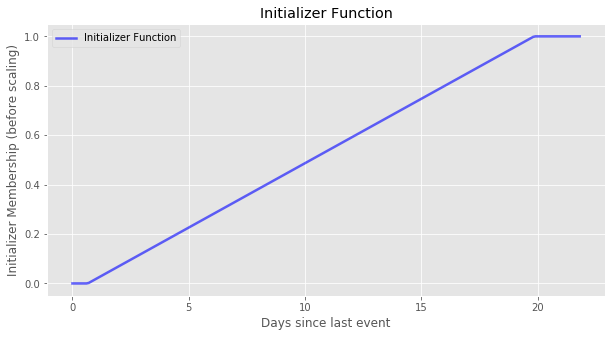

In [8]:
day_range = np.arange(0, estimated_membership_functions['initializer']['end_function_time_days']+2.0, 0.1)

fig = plt.figure(figsize=(10,5))
plt.title('Initializer Function')
plt.plot(day_range, [ linear_membership(t, 
                                        a=estimated_membership_functions['initializer']['end_function_time_days'], 
                                        x_offset=estimated_membership_functions['initializer']['start_function_time_days']
                                       ) for t in day_range], 
         label='Initializer Function', alpha=0.6, linewidth=2.5, color='blue')
plt.legend()
plt.xlabel('Days since last event')
plt.ylabel('Initializer Membership (before scaling)')

plt.show()

### Closer

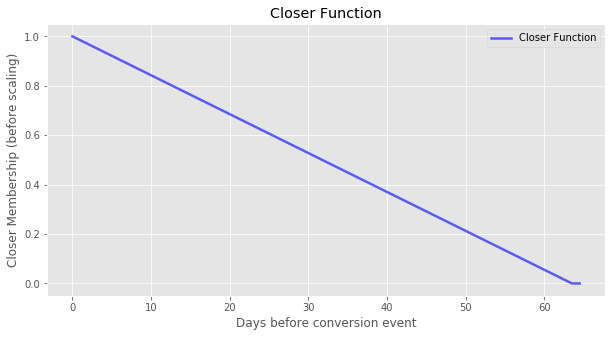

In [9]:
day_range = np.arange(0, estimated_membership_functions['closer']['end_function_time_days']+1.0, 0.1)

fig = plt.figure(figsize=(10,5))
plt.title('Closer Function')
plt.plot(day_range, [ 1.0 - linear_membership(t, 
                                        a=estimated_membership_functions['closer']['end_function_time_days'], 
                                        x_offset=estimated_membership_functions['closer']['start_function_time_days']
                                       ) for t in day_range],
         label='Closer Function', alpha=0.6, linewidth=2.5, color='blue')
plt.legend()
plt.xlabel('Days before conversion event')
plt.ylabel('Closer Membership (before scaling)')

plt.show()

## Visualize Initializer and Closer End Value Distributions

### Initializer End Value Distribution

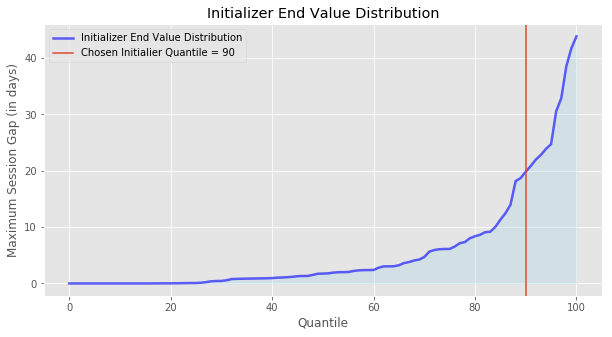

In [10]:
percentile_range = np.arange(0, 101)

fig = plt.figure(figsize=(10,5))
plt.title('Initializer End Value Distribution')
plt.plot(percentile_range, initializer_end_value_distribution, 
         label='Initializer End Value Distribution', alpha=0.6, linewidth=2.5, color='blue')
plt.axvline(x=int(initializer_quantile), label='Chosen Initialier Quantile = ' + str(initializer_quantile))
plt.legend()
plt.fill_between(percentile_range, initializer_end_value_distribution, color="skyblue", alpha=0.2)

plt.xlabel('Quantile')
plt.ylabel('Maximum Session Gap (in days)')

plt.show()

### Closer End Value Distribution

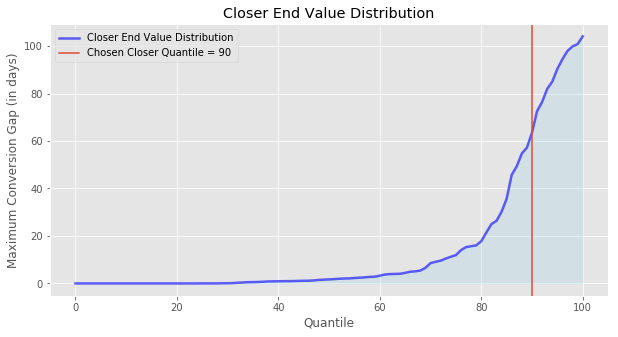

In [11]:
percentile_range = np.arange(0, 101)

fig = plt.figure(figsize=(10,5))
plt.title('Closer End Value Distribution')
plt.plot(percentile_range, closer_end_value_distribution, 
         label='Closer End Value Distribution', alpha=0.6, linewidth=2.5, color='blue')
plt.axvline(x=int(closer_quantile), label='Chosen Closer Quantile = ' + str(closer_quantile))
plt.legend()
plt.fill_between(percentile_range, closer_end_value_distribution, color="skyblue", alpha=0.2)

plt.xlabel('Quantile')
plt.ylabel('Maximum Conversion Gap (in days)')

plt.show()

----

## Check stored IHC Parameter(s)

## endpoint: /get-stored-ihc-parameter

Now we want to get and print the stored IHC parameter.

In [12]:
response = requests.get(
    api_url + '/get-stored-ihc-parameter', 
    headers= {
        'Content-Type': 'application/json',    
        'x-api-key': api_key
    }
) 
ihc_para_stored = json.loads(response.content)
pprint.pprint( ihc_para_stored )

[{'Account': 'ihc-webservice-test-account',
  'Conv_Code': 'ihc-webservice-test-conv_code',
  'IHC_Parameter': '{"membership_functions": {"initializer": '
                   '{"start_function_time_days": 0.66, '
                   '"end_function_time_days": 19.84, "function": "linear", '
                   '"function_parameter": {}}, "closer": '
                   '{"start_function_time_days": 0, "end_function_time_days": '
                   '63.51, "function": "linear", "function_parameter": {}}}}',
  'Market': 'INT'}]
